# Breastfeeding survey analysis

This notebook analyses the survey responses to Jessica Barton's breastfeeding questionnaire.

Items

  - Summarize population (number screened, criteria, >= 18 years old, Mirena usage positive or negative)
  - Within population, summarize demographic factors (age, race, ethnicity, education, income, marital status), exposure, covariates, and outcome
  - Exposure: Mirena usage
  - Covariates:
    - Hormonal issues (how defined?)
    - Difficulty conceiving
    - Age of baby at start of birth control (Morena?)
    - Age of mother
    - Mother overweight
  - Outcome: milk supply went down
  
  - Describe unadjusted "rate" of outcome for each birth control type
  - Describe "rate" adjusted for covariates for each birth control type?

## Setup and read in the data

In [1]:
import sqlite3
import numpy as np
import pandas as pd
from pandas.io.sql import read_sql_query

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
conn = sqlite3.connect('../data/analysis.sqlite3')
curs = conn.cursor()
curs.execute("attach database '../data/codes.sqlite3' as codes;")

population_query = '''
    select RespondentId, sex, age_yc, bf_status, age_mother, AP, AP_reason
    from survey
'''

population = read_sql_query(population_query, conn)
survey = read_sql_query('select * from survey where AP = 1', conn)

def table(column, connection=conn):
    '''Query a database to summarize a coded variable using its code table'''
    query = '''
        select c.Code, c.Description, count(*) as n
        from survey as s left join codes.{} as c on s.{} = c.Code
        group by c.Code, c.Description
        order by 1
    '''.format(column, column, column)
    
    t = read_sql_query(query, connection)
    n = t.n[t.Code.notnull()]
    t['%'] = n/n.sum()
    
    return t

In [3]:
population.head()

,RespondentID,sex,age_yc,bf_status,age_mother,AP,AP_reason
0,2503542169,2,2.0,NaN,NaN,0,2
1,2503602344,2,1.0,1.0,29.0,1,0
2,2503604232,2,1.0,1.0,32.0,1,0
3,2503605645,2,1.0,1.0,32.0,1,0
4,2503606246,2,1.0,1.0,32.0,1,0


## Summarize enrollment

In [4]:
read_sql_query('''
    select 0 as Code, 'Total screened' as Description, count(*) as n
    from survey
        union all
    select a.Code, a.Description, count(*) as n
    from codes.AP_reason as a
        inner join survey as s
            on a.Code = s.AP_reason
    group by a.Code, a.Description
        union all
    select 10 as Code, 'Total included in analysis population', count(*) as n
    from survey
    where AP = 1
    order by 1
''', conn).set_index(['Code', 'Description'])

,,n
Code,Description,
0,Total screened,4688
1,Respondent was male,8
2,Youngest child older than 18 months,391
3,Youngest child weaned more than 18 months ago,7
4,Youngest child never breastfed,10
5,Respondent not confirmed 18 years or older,540
10,Total included in analysis population,3732


In [5]:
# Check total
4688 - (8 + 391 + 7 + 10 + 540)

3732

Based on the above, 4,688 attempted with survey, with 8 being excluded for being male, 391 for not having a young enough child, 7 for having weaned too long ago, 10 for never having breastfed their youngest child, and 540 for being too young (or not having clean enough data to show how old they were). A total of 3,732 are therefore eligible to be included in the main analysis.

Parenthetically, the age restriction is a bit conservative. As we only collected birth year and all of the surveys were completed in 2013, age was computed as the smallest possible age (that is, as age before birthday in 2013).

### Demographics and other characteristics

In [6]:
survey[['age_mother']].describe()

,age_mother
count,3732.000000
mean,30.379957
std,4.411652
min,18.000000
25%,28.000000
50%,30.000000
75%,33.000000
max,48.000000


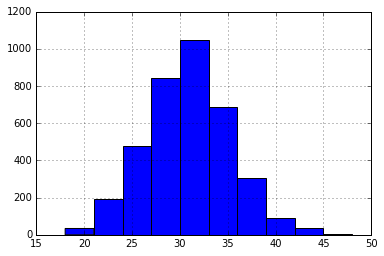

In [7]:
survey.age_mother.hist()

In [8]:
categoricals = ['race', 'ethnicity', 'education', 'income', 'marital_status']
tables = [table(c) for c in categoricals]
pd.concat(tables, keys=categoricals)

Code                                   Description     n  \
race           0    NaN                                          None   861   
               1    1.0                                         White  3568   
               2    2.0                     Black or African-American    45   
               3    3.0             American Indian or Alaskan Native    23   
               4    4.0                                         Asian    47   
               5    5.0     Native Hawaiian or other Pacific Islander     9   
               6    6.0                           From multiple races   135   
ethnicity      0    NaN                                          None   887   
               1    1.0                            Hispanic or Latino   213   
               2    2.0                        Not Hispanic or Latino  3588   
education      0    NaN                                          None   800   
               1    1.0                  Less than high school degree    25   
               2    2.0  High school degree or equivalent (e.g., GED)   186   
               3    3.0                    Some college but no degree   740   
               4    4.0                              Associate degree   390   
               5    5.0                               Bachelor degree  1500   
               6    6.0                               Graduate degree  1047   
income         0    NaN                                          None   948   
               1    1.0                            Less than \$10,000    66   
               2    2.0                           \$10,000 - \$19,000   105   
               3    3.0                           \$20,000 - \$29,000   235   
               4    4.0                           \$30,000 - \$39,000   329   
               5    5.0                           \$40,000 - \$49,000   318   
               6    6.0                           \$50,000 - \$59,000   338   
               7    7.0                           \$60,000 - \$69,000   342   
               8    8.0                           \$70,000 - \$79,000   378   
               9    9.0                           \$80,000 - \$89,000   326   
               10  10.0                           \$90,000 - \$99,000   301   
               11  11.0                         \$100,000 - \$149,000   683   
               12  12.0                             \$150,000 or More   319   
marital_status 0    NaN                                          None   801   
               1    1.0                                       Married  3571   
               2    2.0                                       Widowed     7   
               3    3.0                                      Divorced    41   
               4    4.0                                     Separated    22   
               5    5.0                                 Never married   246   

                          %  
race           0        NaN  
               1   0.932323  
               2   0.011759  
               3   0.006010  
               4   0.012281  
               5   0.002352  
               6   0.035276  
ethnicity      0        NaN  
               1   0.056038  
               2   0.943962  
education      0        NaN  
               1   0.006430  
               2   0.047840  
               3   0.190329  
               4   0.100309  
               5   0.385802  
               6   0.269290  
income         0        NaN  
               1   0.017647  
               2   0.028075  
               3   0.062834  
               4   0.087968  
               5   0.085027  
               6   0.090374  
               7   0.091444  
               8   0.101070  
               9   0.087166  
               10  0.080481  
               11  0.182620  
               12  0.085294  
marital_status 0        NaN  
               1   0.918703  
               2   0.001801  
               3   0.010548  
               4   0.005660  
               

### Quick summary of body mass index within the population

This is a little different from the analysis that Frances already ran. Not sure why, since we're looking at the same data...

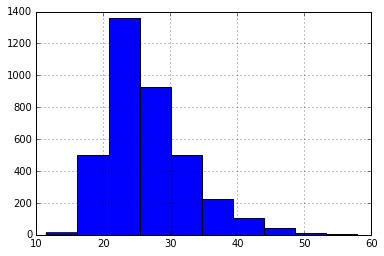

In [9]:
survey.bmi.hist()

In [10]:
table('bmi_category')

,Code,Description,n,%
0,NaN,None,480,NaN
1,1.0,Underweight,129,0.030656
2,2.0,Normal weight,1914,0.454848
3,3.0,Overweight,1151,0.273527
4,4.0,Obese,1014,0.240970
